#### Installation

In [3]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install extcolors
!pip install colorthief

In [8]:
!pip install pymatting

### Importing

In [2]:
import extcolors
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image

2023-02-09 15:28:05.518364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 이미지의 주요 색깔 추출하기

In [4]:
from colorthief import ColorThief
import matplotlib.pyplot as plt
import colorsys

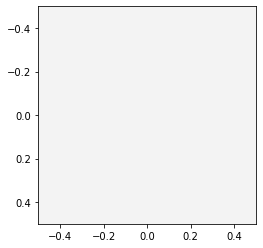

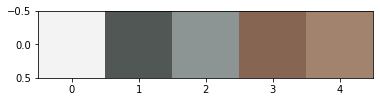

In [8]:
ct = ColorThief("sports_009.jpg")
dominant_color = ct.get_color(quality=1)

plt.imshow([[dominant_color]])
plt.show()

palette = ct.get_palette(color_count=5)
plt.imshow([[palette[i] for i in range(5)]])
plt.show()

### 이미지에서 색상 RGB16 코드값을 추출하기

In [3]:
img = Image.open("sports_009.jpg")
colors, pixel_count = extcolors.extract_from_image(img)

pixel_output = 0
for c in colors:
        pixel_output += c[1]
        print(f'{c[0]} : {round((c[1] / pixel_count) * 100, 2)}% ({c[1]})')
print(f'Pixels in output: {pixel_output} of {pixel_count}')

(246, 246, 246) : 81.09% (62886)
(130, 139, 138) : 16.23% (12584)
(32, 32, 30) : 2.67% (2069)
(132, 79, 65) : 0.01% (11)
Pixels in output: 77550 of 77550


### Feature Extraction

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tqdm import tqdm
from pathlib import Path

#### VGG16 기반 base Model 구축하기

In [46]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        print(base_model.summary())
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

#### Feature 저장하기

In [59]:
features = []
img_paths = []
categories = ['americancasual', 'casual', 'dandy', 'formal', 'sports', 'street']

fe = FeatureExtractor()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
import os
os.mkdir("./features")

In [60]:
for i in range(len(categories)):
    print("Category : " , categories[i])
    for j in range(2, 62):
        try:
            image_path = "./fashion_dataset/" + categories[i] + "/" + categories[i] +  "_" + str(j).zfill(3) + ".jpg"
            img_paths.append(image_path)
            
            feature = fe.extract(img=Image.open(image_path))
            features.append(feature)
            
            feature_path = "./features/" + categories[i] + str(j).zfill(3) + ".npy"
            np.save(feature_path, feature)
        except Exception as e:
            print("예외가 발생했습니다.", e)

Category :  americancasual
1/1 [==============================] - 0s 339ms/step
예외가 발생했습니다. [Errno 2] No such file or directory: './fashion_dataset/americancasual/americancasual_036.jpg'
1/1 [==============================] - 0s 264ms/step
Category :  casual
1/1 [==============================] - 0s 302ms/step
Category :  dandy
1/1 [==============================] - 0s 315ms/step
Category :  formal
1/1 [==============================] - 0s 423ms/step
Category :  sports
1/1 [==============================] - 0s 301ms/step
Category :  street
1/1 [==============================] - 0s 302ms/step


#### 유사 이미지 탐색

1/1 [==============================] - 1s 855ms/step


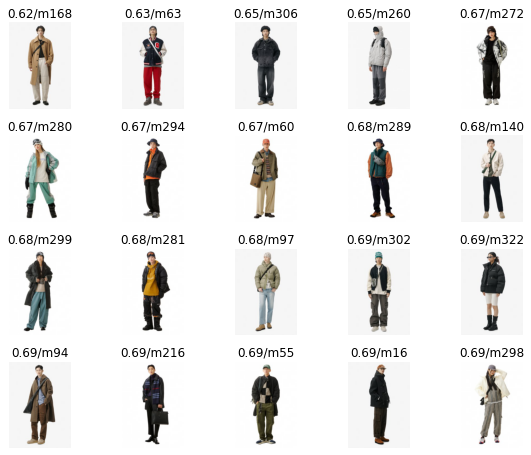

In [62]:
img = Image.open("./americancasual_036.jpg")
query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

ids = np.argsort(dists)[:20]

scores = [(dists[id], img_paths[id], id) for id in ids]

axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*4):
    score = scores[a]
    axes.append(fig.add_subplot(5, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2]+1)
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()